In [17]:
import sys
sys.setrecursionlimit(2000)  # Set a higher recursion limit

In [18]:
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import squareform
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import numpy as np
import time
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv


In [19]:
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.sparse.linalg import svds
from scipy.linalg import eigh
from scipy.sparse.linalg import eigs

from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvnpdf
import cvxpy as cp
import time
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from numpy.matlib import repmat
import scipy.sparse as sp

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv

import numpy as np
import time
from scipy.sparse import csr_matrix

from scipy.sparse.linalg import svds

import numpy as np
from scipy.spatial.distance import squareform
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score

In [20]:
def visualize_glmm(Ls, gamma_hats):
    k = gamma_hats.shape[1]
    n = Ls.shape[0]
    
    G = nx.Graph()
    
    for i in range(n):
        G.add_node(i)
    
    for l in range(k):
        L = Ls[:, :, l]
        for i in range(n):
            for j in range(i+1, n):
                if L[i, j] != 0:
                    G.add_edge(i, j, weight=L[i, j])
    
    colors = []
    for i in range(n):
        cluster = np.argmax(gamma_hats[i])
        colors.append(cluster)
    
    pos = nx.spring_layout(G)  
    
    nx.draw_networkx_nodes(G, pos, node_size=700, cmap=plt.cm.RdYlBu, node_color=colors)
    
    edges = G.edges(data=True)
    weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    
    plt.title('Graph Laplacian Mixture Model (GLMM) Visualization')
    plt.show()
    

def graph_learning_perf_eval(L_0, L):
    """
    Evaluates the performance of a learned graph by comparing it with the ground truth Laplacian matrix.

    Parameters:
    -----------
    L_0 : np.ndarray
        Ground truth Laplacian matrix of shape (n, n).
    
    L : np.ndarray
        Learned Laplacian matrix of shape (n, n).

    Returns:
    --------
    precision : float
        Precision score of the learned graph.
    
    recall : float
        Recall score of the learned graph.
    
    f : float
        F1 score of the learned graph.
    
    NMI_score : float
        Normalized Mutual Information score of the learned graph.
    
    num_of_edges : int
        Number of edges in the learned graph.
    """
    # Edges in the ground truth graph
    L_0tmp = L_0 - np.diag(np.diag(L_0))
    L_0tmp = (L_0tmp + L_0tmp.T) / 2  
    edges_groundtruth = squareform(L_0tmp) != 0

    # Edges in the learned graph
    Ltmp = L - np.diag(np.diag(L))
    Ltmp = (Ltmp + Ltmp.T) / 2  
    edges_learned = squareform(Ltmp) != 0

    # Compute precision, recall, F1-score
    precision = precision_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    recall = recall_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)
    f = f1_score(edges_groundtruth.astype(int), edges_learned.astype(int), zero_division=0)

    # NMI
    NMI_score = normalized_mutual_info_score(edges_learned.astype(int), edges_groundtruth.astype(int))
    if np.isnan(NMI_score):
        NMI_score = 0

    # Number of edges in the learned graph
    num_of_edges = np.sum(edges_learned)

    return precision, recall, f, NMI_score, num_of_edges


import numpy as np

def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
    """
    Identifies and compares clusters based on given Laplacian matrices and cluster assignments.

    Parameters:
    -----------
    Ls : np.ndarray
        Estimated Laplacian matrices of shape (n, n, k).
    
    Lap : np.ndarray
        Ground truth Laplacian matrices of shape (n, n, k).
    
    gamma_hats : np.ndarray
        Estimated cluster assignments of shape (m, k).
    
    gamma_cut : np.ndarray
        Ground truth cluster assignments of shape (m, k).
    
    k : int
        Number of clusters.

    Returns:
    --------
    identify : np.ndarray
        Indices of the identified clusters of shape (k,).
    
    precision : np.ndarray
        Precision scores for each cluster of shape (k,).
    
    recall : np.ndarray
        Recall scores for each cluster of shape (k,).
    
    f : np.ndarray
        F1 scores for each cluster of shape (k,).
    
    cl_errors : np.ndarray
        Clustering errors for each cluster of shape (k,).
    
    NMI_score : np.ndarray
        Normalized Mutual Information scores for each cluster of shape (k,).
    
    num_of_edges : np.ndarray
        Number of edges for each cluster of shape (k,).
    """
    identify = np.zeros(k, dtype=int)
    cl_err = np.inf * np.ones(k)
    precision = np.zeros(k)
    recall = np.zeros(k)
    f = np.zeros(k)
    NMI_score = np.zeros(k)
    num_of_edges = np.zeros(k)

    for i in range(k):
        W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
        W[W < 0.001] = 0
        Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
        for j in range(k):
            er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j])
            if cl_err[i] > er:
                cl_err[i] = er
                identify[i] = j

    for i in range(k):
        idx = identify[i]
        precision[i], recall[i], f[i], NMI_score[i], num_of_edges[i] = graph_learning_perf_eval(Lap[:, :, idx], Ls[:, :, i])

    # Compute clustering errors
    cl_errors = np.array([np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, identify[i]]) for i in range(k)])

    return identify, precision, recall, f, cl_errors, NMI_score, num_of_edges



def generate_connected_graph(n, p, zero_thresh):
    """
    Generates a connected Erdos-Renyi graph and returns its Laplacian matrix.

    Parameters:
    -----------
    n : int
        Number of nodes in the graph.
    
    p : float
        Probability for edge creation in the Erdos-Renyi graph.
    
    zero_thresh : float
        Threshold for the second smallest eigenvalue of the Laplacian matrix
        to ensure graph connectivity.

    Returns:
    --------
    np.ndarray
        Laplacian matrix of the generated connected graph.
    """
    while True:
        g = nx.erdos_renyi_graph(n, p)
        L = nx.laplacian_matrix(g).toarray()
        eigs = np.sort(eigvals(L))
        if eigs[1] > zero_thresh:
            return L

In [21]:
def normest(S):
    """
    Estimate the 2-norm (largest singular value) of a sparse matrix S.
    """
    u, s, vt = svds(S, k=1)
    return s[0]


In [22]:
def lin_map(X, lims_out, lims_in=None):
    """
    Map linearly from a given range to another.

    Parameters:
    X : array-like
        Input array.
    lims_out : list or tuple
        Output limits [c, d].
    lims_in : list or tuple, optional
        Input limits [a, b]. If not specified, the minimum and maximum values of X are used.

    Returns:
    Y : array-like
        Linearly mapped output array.
    """
    X = np.asarray(X)
    
    if lims_in is None:
        lims_in = [np.min(X), np.max(X)]
    
    a, b = lims_in
    c, d = lims_out
    
    Y = (X - a) * ((d - c) / (b - a)) + c
    return Y

In [23]:
def squareform_sp(w):
    """
    Sparse counterpart of numpy's squareform
    
    Parameters:
    w : sparse or dense vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
    Returns:
    W : matrix form of input vector w OR vector form of input matrix W
    """
    import numpy as np
    import scipy.sparse as sp
    from scipy.spatial.distance import squareform

    if sp.issparse(w):
        is_sparse = True
    else:
        is_sparse = False
        w = np.asarray(w)
    
    # Determine if input is a vector
    if w.ndim == 1 or w.shape[0] == 1 or w.shape[1] == 1:
        # VECTOR -> MATRIX
        if w.ndim == 1:
            l = w.shape[0]
        else:
            l = w.shape[0] * w.shape[1]
        n = int(round((1 + np.sqrt(1 + 8*l)) / 2))
        
        # Check input
        if l != n*(n-1)//2:
            raise ValueError("Bad vector size!")
        
        if is_sparse:
            ind_vec = w.nonzero()[0]
            s = w.data
        else:
            ind_vec = np.nonzero(w)[0]
            s = w[ind_vec]
        
        num_nz = len(ind_vec)
        
        ind_i = np.zeros(num_nz, dtype=int)
        ind_j = np.zeros(num_nz, dtype=int)
        
        curr_row = 0
        offset = 0
        len_row = n - 1
        for idx in range(num_nz):
            ind_vec_i = ind_vec[idx]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            ind_i[idx] = curr_row
            ind_j[idx] = ind_vec_i - offset + curr_row + 1
        
        # For the lower triangular part, add the transposed matrix
        data = np.concatenate([s, s])
        row_indices = np.concatenate([ind_i, ind_j])
        col_indices = np.concatenate([ind_j, ind_i])
        W = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
        return W

    else:
        # MATRIX -> VECTOR
        m, n = w.shape
        if m != n or not np.all(w.diagonal() == 0):
            raise ValueError("Matrix has to be square with zero diagonal!")
        
        if is_sparse:
            ind_i, ind_j = w.nonzero()
            s = w.data
        else:
            ind_i, ind_j = np.nonzero(w)
            s = w[ind_i, ind_j]
        
        # Keep only upper triangular part
        ind_upper = ind_i < ind_j
        ind_i = ind_i[ind_upper]
        ind_j = ind_j[ind_upper]
        s = s[ind_upper]
        
        # Compute new (vector) index from (i,j) (matrix) indices
        new_ind = n * ind_i - ind_i * (ind_i + 1) // 2 + ind_j - ind_i - 1
        l = n * (n - 1) // 2
        w_vec = sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), shape=(l, 1))
        return w_vec


In [24]:

def sum_squareform(n, mask=None):
    """
    Computes the sum and transpose sum matrices in a squareform format.

    Parameters:
    -----------
    n : int
        The size of the squareform matrix.
    
    mask : array-like, optional
        A mask to filter the indices. The length of the mask must be n(n-1)/2.
        If provided, only the elements corresponding to the non-zero values in
        the mask are considered.

    Returns:
    --------
    S : csr_matrix
        A sparse matrix so that S * w = sum(W), where w = squareform(W)
    
    St : csr_matrix
        The adjoint (transpose) of S.

    Raises:
    -------
    ValueError
        If the length of the mask is not equal to n(n-1)/2.
    """
    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i > (len_row + offset - 1):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1
    else:
        ncols = n * (n - 1) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n - 1):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    # Construct St
    row_indices = np.concatenate([np.arange(ncols), np.arange(ncols)])
    col_indices = np.concatenate([I, J])
    data = np.ones(2 * ncols)

    St = csr_matrix((data, (np.arange(2 * ncols), col_indices)), shape=(2 * ncols, n))
    St = csr_matrix((data, (row_indices, col_indices)), shape=(ncols, n))
    S = St.transpose()

    return S, St



In [25]:

def prox_sum_log(x, gamma, param=None):
    """
    Proximal operator of log-barrier - sum(log(x))

    Solves:
        sol = argmin_{z} 0.5*||x - z||_2^2 - gamma * sum(log(z))

    Parameters:
    ----------
    x : array-like
        Input signal (vector or matrix).
    gamma : float
        Regularization parameter.
    param : dict, optional
        Dictionary of optional parameters:
        - 'verbose': int, verbosity level (default: 1).

    Returns:
    -------
    sol : numpy.ndarray
        Solution to the optimization problem.
    info : dict
        Dictionary summarizing information at convergence.
    """
    if param is None:
        param = {}
    
    verbose = param.get('verbose', 1)
    
    if gamma < 0:
        raise ValueError('Gamma cannot be negative')
    elif gamma == 0:
        stop_error = True
    else:
        stop_error = False
    
    t1 = time.time()
    
    if stop_error:
        sol = x
        info = {
            'algo': 'prox_sum_log',
            'iter': 0,
            'final_eval': 0,
            'crit': '--',
            'time': time.time() - t1
        }
        return sol, info
    
    # Compute the solution
    sol = (x + np.sqrt(x**2 + 4*gamma)) / 2
    
    # Compute the final evaluation of the function at the solution
    final_eval = 0.5 * np.sum((x - sol)**2) - gamma * np.sum(np.log(sol.flatten()))
    
    info = {
        'algo': 'prox_sum_log',
        'iter': 0,
        'final_eval': final_eval,
        'crit': '--',
        'time': time.time() - t1
    }
    
    # Verbose output
    if verbose >= 1:
        print(f'  prox_sum_log: final evaluation = {info["final_eval"]:.6e}')
        if verbose > 1:
            n_neg = np.sum(sol.flatten() <= 0)
            if n_neg > 0:
                print(f' ({n_neg} negative elements in solution, log not defined, check stability)')
        print()
    
    return sol, info


In [26]:


def gsp_distanz(X, Y=None, P=None):
    """
    Calculates the distances between all vectors in X and Y using a provided matrix P for scaling (weighted distances).
    
    Parameters:
        X (numpy.ndarray): Matrix with column vectors of shape (n_features, n_samples_X).
        Y (numpy.ndarray, optional): Matrix with column vectors of shape (n_features, n_samples_Y). Defaults to X.
        P (numpy.ndarray, optional): Weight matrix of shape (n_features, n_features). Defaults to the identity matrix.

    Returns:
        numpy.ndarray: Distance matrix of shape (n_samples_X, n_samples_Y), not squared.
        
    Raises:
        ValueError: If the dimensions of X and Y do not match.
        ValueError: If the dimensions of P do not match the number of features in X.

    Usage:
        D = gsp_distanz(X, Y, P)
        
    Notes:
        This function computes the following:
        
            D = sqrt((X - Y)^T P (X - Y))
        
        for all vectors in X and Y. If P is not provided, it defaults to the identity matrix, reducing the calculation to the Euclidean distance.
        The function is optimized for speed using vectorized operations, avoiding explicit loops.
    """
    if Y is None:
        Y = X

    if X.shape[0] != Y.shape[0]:
        raise ValueError("The sizes of X and Y do not match!")

    n_features, n_samples_X = X.shape
    _, n_samples_Y = Y.shape

    if P is None:
        xx = np.sum(X**2, axis=0)  # ||x||^2, shape (n_samples_X,)
        yy = np.sum(Y**2, axis=0)  # ||y||^2, shape (n_samples_Y,)
        xy = X.T @ Y               # x^T y, shape (n_samples_X, n_samples_Y)
        D = np.abs(np.add.outer(xx, yy) - 2 * xy)
    else:
        rp, rp2 = P.shape
        if n_features != rp or rp != rp2:
            raise ValueError("P must be square and match the dimension of X!")

        # Compute x^T P x and y^T P y
        xx = np.sum(X * (P @ X), axis=0)  # shape (n_samples_X,)
        yy = np.sum(Y * (P @ Y), axis=0)  # shape (n_samples_Y,)

        # Compute x^T P y and y^T P x
        xy = X.T @ (P @ Y)  # shape (n_samples_X, n_samples_Y)
        yx = Y.T @ (P @ X)  # shape (n_samples_Y, n_samples_X)

        # D = |xx_i + yy_j - (x_i^T P y_j) - (y_j^T P x_i)|
        # Since yx.T has shape (n_samples_X, n_samples_Y), we can subtract it directly
        D = np.abs(np.add.outer(xx, yy) - xy - yx.T)

    # Check for negative values in D
    if np.any(D < 0):
        print('Warning: P is not semipositive or x is not real!')

    # Take the square root
    D = np.sqrt(D)

    # If Y is X, set the diagonal to zero
    if Y is X:
        np.fill_diagonal(D, 0)

    return D



In [27]:

def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    """
    Learns a graph structure by optimizing a log-degrees model.

    Parameters:
    -----------
    Z : array-like
        Input data matrix or condensed distance matrix.

    a : float
        Coefficient for the logarithmic penalty term.

    b : float
        Regularization coefficient.

    params : dict, optional
        A dictionary of optional parameters:
        - 'W_init': Initial weight matrix (default: zeros)
        - 'verbosity': int, level of verbosity (default: 1)
        - 'maxit': int, maximum number of iterations (default: 1000)
        - 'tol': float, tolerance for convergence (default: 1e-5)
        - 'step_size': float, step size for the gradient descent (default: 0.5)
        - 'max_w': float, maximum allowable weight (default: np.inf)
        - 'w_0': array-like or int, initial weight matrix or value (default: 0)
        - 'c': float, regularization coefficient for initial weight matrix
        - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
        - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

    Returns:
    --------
    W : array-like
        The learned weight matrix.

    stat : dict
        Optional output statistics.

    Raises:
    -------
    ValueError
        If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
    """

    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)  # From (0, 1)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)

    # # Process Z
    # if isinstance(Z, np.ndarray) and Z.ndim == 1:
    #     z = Z.copy()
    # else:
    #     z = squareform_sp(Z)

    # z = z.toarray().flatten()
    
    
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    elif sp.issparse(Z):  # Check if Z is a sparse matrix
        z = squareform_sp(Z).toarray().flatten()  # Convert sparse matrix to dense and flatten
    else:
        z = squareform_sp(Z)
        if isinstance(z, np.ndarray):  # Ensure z is a numpy array before flattening
            z = z.flatten()

    # Determine length appropriately
    if sp.issparse(z):  # If z is still sparse
        l = z.getnnz()  # Use the number of non-zero elements
    else:
        l = len(z)  # Use standard length for dense arrays
 
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if 'w_0' in params:
        w_0 = params['w_0']
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
    else:
        w_0 = 0

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    z = z.astype(np.float64)
    if not np.isscalar(w_0):
        w_0 = w_0.astype(np.float64)

    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)
        
    print("Type of S:", type(S))
    print("Type of w:", type(w))
    print("Shape of S:", S.shape)
    print("Shape of w:", w.shape if hasattr(w, 'shape') else "Scalar or undefined")


    K_op = lambda w: S.multiply(w) if np.isscalar(w) or w.shape == () else S @ w



    # S': nodes -> edges
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = norm_est(S)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    g_prox = lambda s, c: prox_sum_log(s, c * a, param_prox_log)[0]
    g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]

    if np.all(w_0 == 0):
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: 2 * ((b + c) * w - c * w_0)
        h_beta = 2 * (b + c)

    # Parameters for convergence
    mu = h_beta + norm_K
    gn = step_size / mu  # Step size in (0, 1/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            if verbosity > 2:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')
            else:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    stat['time'] = total_time

    if verbosity > 0:
        final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
        print(f'Time needed is {total_time:.4f} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform_sp(w)

    return W, stat


In [28]:


def glmm(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM)
    
    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.
    
    iterations : int
        The number of iterations for the algorithm.
    
    classes : int
        The number of clusters (classes).
    
    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).
    
    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).
    
    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).
    
    mu : np.ndarray
        The cluster means of shape (n, classes).
    
    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """
    delta = 2
    m, n = y.shape

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n - 1, n - 1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n - 1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - (spread / n) * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = np.zeros(m)
        for cls in range(classes):
            # Eigenvalue decomposition
            eig_vals, eig_vecs = np.linalg.eigh(L[:, :, cls])
            vecl[:, :, cls] = eig_vecs
            vall[:, :, cls] = np.diag(eig_vals)

            # Build sigma
            sigma_matrix = np.diag(eig_vals[1:]) + regul * np.eye(n - 1)
            sigma[:, :, cls] = inv(sigma_matrix)
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2  # Ensure symmetry

            # Compute yl
            yl[:, :, cls] = (y - mu[:, cls]) @ vecl[:, 1:, cls]

            # Compute probability densities
            pdf_vals = multivariate_normal.pdf(yl[:, :, cls], mean=np.zeros(n - 1), cov=sigma[:, :, cls], allow_singular=True)
            pall += p[cls] * pdf_vals

        # Avoid zeros in pall to prevent division by zero
        pall[pall == 0] = np.finfo(float).eps

        # Compute cluster probabilities gamma_hat
        for cls in range(classes):
            pdf_vals = multivariate_normal.pdf(yl[:, :, cls], mean=np.zeros(n - 1), cov=sigma[:, :, cls], allow_singular=True)
            gamma_hat[:, cls] = (p[cls] * pdf_vals) / pall

        # Compute log-likelihood
        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            # Update mu
            mu[:, cls] = (gamma_hat[:, cls] @ y) / np.sum(gamma_hat[:, cls])

            # Compute yc
            sqrt_gamma = np.sqrt(gamma_hat[:, cls])[:, np.newaxis]
            yc = sqrt_gamma * (y - mu[:, cls])

            # Compute Z
            Z = gsp_distanz(yc) ** 2

            # Compute theta
            theta = np.mean(Z) / norm_par

            # Compute W_curr
            W_curr, _ = gsp_learn_graph_log_degrees(Z / theta, 1, 1)
            W_curr = delta * W_curr

            # Threshold W_curr
            W_curr[W_curr < 1e-3] = 0

            # Update W
            W[:, :, cls] = W_curr

            # Update p
            p[cls] = np.sum(gamma_hat[:, cls]) / m

            # Compute L
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]

    return L, gamma_hat, mu, log_likelihood


In [29]:
# import numpy as np
# import time
# from scipy.sparse import csr_matrix
# from scipy.sparse.linalg import norm as sparse_norm
# from scipy.spatial.distance import squareform
# from scipy.optimize import minimize_scalar

# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix (squared pairwise distances).

#     a : float
#         Coefficient for the logarithmic penalty term (controls connectivity).

#     b : float
#         Regularization coefficient (controls sparsity).

#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'c': float, regularization coefficient for initial weight matrix
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix (n x n).

#     stat : dict
#         Output statistics including convergence information.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     # Default parameters
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     # Initialize z
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z.copy()
#     else:
#         z = squareform_sp(Z)

#     z = z.toarray().flatten()
#     z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
#     l = len(z)
#     n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

#     # Handle w_0
#     if not np.isscalar(w_0) or w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0.copy()
#         else:
#             w_0 = squareform_sp(w_0)
#         w_0 = w_0.flatten()
#         w_0 = np.asarray(w_0, dtype=float)
#     else:
#         w_0 = 0
#         c = 0  # Ensure c is defined

#     # Handle fix_zeros
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform_sp(edge_mask)
#         ind = np.nonzero(edge_mask.flatten())[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     # Initialize w
#     w = np.zeros_like(z)

#     # Needed operators
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = sparse_norm(S, ord=2)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # Define functions f, g, h
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda s: -a * np.sum(np.log(s))
#     # g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)
#     # g_star_prox = lambda z_in, c_in: np.asarray(z_in) - c_in * a * prox_sum_log(np.asarray(z_in) / (c_in * a), 1 / (c_in * a), param_prox_log)
#     g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]


#     # Corrected h_eval and h_grad with division by 2
#     if np.all(w_0 == 0):
#         # No prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2
#         h_grad = lambda w: b * w
#         h_beta = b  # Lipschitz constant of h_grad
#     else:
#         # With prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2 + (c / 2) * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: b * w + c * (w - w_0)
#         h_beta = b + c  # Lipschitz constant of h_grad

#     # Parameters for convergence
#     mu = h_beta + norm_K
#     epsilon = 1e-6  # A small positive value
#     gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

#     # Initialize variables
#     v_n = K_op(w)

#     stat = {}
#     if verbosity > 1:
#         stat['f_eval'] = []
#         stat['g_eval'] = []
#         stat['h_eval'] = []
#         stat['fgh_eval'] = []
#         stat['pos_violation'] = []

#     start_time = time.time()

#     # Iterative optimization
#     for i in range(maxit):
#         # Primal and dual updates
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         # Compute relative norms
#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # Record statistics
#             stat['f_eval'].append(f_eval(w))
#             stat['g_eval'].append(g_eval(K_op(w)))
#             stat['h_eval'].append(h_eval(w))
#             stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
#             stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
#             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

#         # Update variables
#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         # Check convergence
#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     total_time = time.time() - start_time
#     if verbosity > 0:
#         final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
#         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
#         print(f'Time needed is {total_time} seconds')

#     # Reconstruct full weight vector if fix_zeros was used
#     if fix_zeros:
#         w_full = np.zeros(l)
#         w_full[ind] = w
#         w = w_full

#     # Convert vectorized weights back to matrix form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)

#     stat['time'] = total_time

#     return W, stat


In [30]:
import numpy as np
import time
from scipy.sparse.linalg import norm as sparse_norm
from scipy.spatial.distance import squareform

def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)  # Should be in (0, 1)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    # Initialize z
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    else:
        z = squareform_sp(Z)  # Assuming this function is defined and works like MATLAB's

    z = z.toarray().flatten()
    z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
    l = len(z)
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if not np.isscalar(w_0) or w_0 != 0:
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
        w_0 = np.asarray(w_0, dtype=float)
    else:
        w_0 = 0
        c = 0  # Ensure c is defined

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    # Initialize w
    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = sparse_norm(S, ord=2)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)[0]

    if np.all(w_0 == 0):
        # No prior W0
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        # With prior W0
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: 2 * b * w + 2 * c * (w - w_0)
        h_beta = 2 * (b + c)

    # Parameters for convergence
    mu = h_beta + norm_K
    gn = step_size / mu  # Step size in (0, 1/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            if verbosity > 2:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')
            else:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    stat['time'] = total_time

    if verbosity > 0:
        final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
        print(f'Time needed is {total_time:.4f} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform(w)

    return W, stat


# iters:  104. Rel primal: 8.3980e-06 Rel dual: 3.0722e-06  OBJ 1.344e+01
Time needed is 0.0044 seconds
# iters:  103. Rel primal: 9.6146e-06 Rel dual: 3.0953e-06  OBJ 1.345e+01
Time needed is 0.0045 seconds
# iters:  103. Rel primal: 9.9193e-06 Rel dual: 3.0925e-06  OBJ 1.343e+01
Time needed is 0.0052 seconds
# iters:  103. Rel primal: 9.5964e-06 Rel dual: 3.0434e-06  OBJ 1.341e+01
Time needed is 0.0041 seconds
# iters:  103. Rel primal: 9.7370e-06 Rel dual: 3.1417e-06  OBJ 1.342e+01
Time needed is 0.0042 seconds
# iters:  103. Rel primal: 9.6051e-06 Rel dual: 3.0577e-06  OBJ 1.340e+01
Time needed is 0.0046 seconds
# iters:  103. Rel primal: 9.6846e-06 Rel dual: 3.1433e-06  OBJ 1.342e+01
Time needed is 0.0046 seconds
# iters:  103. Rel primal: 9.6280e-06 Rel dual: 3.0725e-06  OBJ 1.340e+01
Time needed is 0.0039 seconds
# iters:  103. Rel primal: 9.6551e-06 Rel dual: 3.1431e-06  OBJ 1.341e+01
Time needed is 0.0041 seconds
# iters:  103. Rel primal: 9.5295e-06 Rel dual: 3.1293e-06  OBJ 

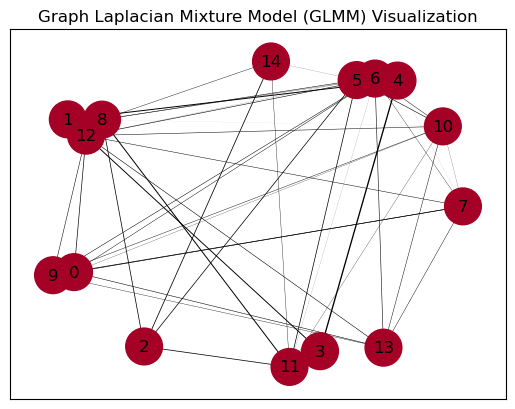

In [31]:

n = 15  
m = 150  
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)